In [310]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# from linearmodels.panel.data import PanelData
# from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
import pyblp

In [311]:
drop_nonself,drop_self=0,0
product_data=pd.read_csv("../../data/merged/len3_ndb_blp_DN_firm_FC.csv",encoding="utf-8",index_col=0)
print(product_data.columns[:30])
product_data=product_data.rename(columns={"薬価":"prices",
                    # "lag_mean_price":"demand_instruments0",
                    # "lag_sum_quantity":"demand_instruments1",
                    # "lag_generic_share_q":"demand_instruments2",
                    "同一剤形・規格の後発医薬品がある先発医薬品":"long_term"})
# "long_term"列の欠損値を0で埋める
product_data["long_term"].fillna(0, inplace=True)
# "long_term"列の"○"を1に置き換える
product_data["long_term"] = product_data["long_term"].replace("○", 1)
# product_data.loc[product_data["メーカー名"]=="sotc","prices"]=product_data.loc[product_data["メーカー名"]=="sotc","mean_price_g"]
# "year"列でフィルタリング
product_data = product_data[product_data["year"] > 2014]
if drop_nonself:
    product_data = product_data[product_data["メーカー名"]!="nonself"]
if drop_self:
    product_data = product_data[product_data["メーカー名"]!="self"]
product_data["product_ids"]=product_data["医薬品名"]

Index(['薬効分類', '薬効分類名称', '医薬品コード', '医薬品名', '薬価基準収載医薬品コード', '薬価', 'generic',
       '総計', 'year', 'in_hospital', 'oral', 'id_l4', 'Approved', 'KEGG',
       'Ingredient', 'date', 'release_year', '成分', 'variable', 'id_x',
       'revenue', 'elapsed', 'elapsed_m6', 'elapsed_m5', 'elapsed_m4',
       'elapsed_m3', 'elapsed_m2', 'elapsed_m1', 'elapsed_0', 'elapsed_1'],
      dtype='object')


C:\Users\hakos\AppData\Local\Temp\ipykernel_45344\1869924167.py:2: DtypeWarning: Columns (118) have mixed types. Specify dtype option on import or set low_memory=False.
  product_data=pd.read_csv("../../data/merged/len3_ndb_blp_DN_firm_FC.csv",encoding="utf-8",index_col=0)


In [312]:
save=1
product_data.loc[:,"market_ids"]=product_data.loc[:,"薬効分類"].astype(int).astype(str)+"-"+product_data.loc[:,"year"].astype(int).astype(str)
product_data.loc[:,"firm_ids"]=product_data.loc[:,"メーカー名"].astype(str)
product_data.loc[:,"shares"]=product_data["総計"]/(120000000*100)


# drop which doesn't have generic
# product_data=product_data[~((product_data["long_term"]==0)&(product_data["generic"]==0))]
product_data=product_data.loc[product_data["shares"]>0]

product_data=product_data[["product_ids","market_ids","firm_ids","prices","brand","oral","generic","in_hospital","薬効分類","year","shares","id_l4","long_term","otc","Pharmacopoeia"]]
product_data=product_data.astype({"prices":float,"shares":float,"oral":float,"generic":int,"otc":int,"in_hospital":int,"long_term":int})
# product_data.loc[product_data["product_ids"]=='otc',"generic"]=0
product_data.reset_index(drop=True,inplace=True)
print(product_data.columns[:20])
print(product_data.shape)

Index(['product_ids', 'market_ids', 'firm_ids', 'prices', 'brand', 'oral',
       'generic', 'in_hospital', '薬効分類', 'year', 'shares', 'id_l4', 'long_term',
       'otc', 'Pharmacopoeia'],
      dtype='object')
(24673, 15)


In [313]:
# product_data["long_term"].value_counts()
# product_data["lag_sum_quantity"].isna().sum()
# product_data.shape


In [314]:
demand_instruments=pyblp.build_blp_instruments(pyblp.Formulation("1+generic+in_hospital+oral+long_term+Pharmacopoeia"),product_data=product_data)
# demand_instruments=pyblp.build_blp_instruments(formulation=pyblp.Formulation("1+prices+generic+oral+in_hospital"),product_data=product_data)
demand_instruments
demand_instruments.shape,product_data.shape

((24673, 12), (24673, 15))

In [315]:
MD=demand_instruments.shape[1]
demand_instruments=pd.DataFrame(demand_instruments, columns=[f'demand_instruments{i}' for i in range(MD)])
product_data=pd.concat([product_data,demand_instruments],axis=1)
product_data.columns,product_data.shape

(Index(['product_ids', 'market_ids', 'firm_ids', 'prices', 'brand', 'oral',
        'generic', 'in_hospital', '薬効分類', 'year', 'shares', 'id_l4', 'long_term',
        'otc', 'Pharmacopoeia', 'demand_instruments0', 'demand_instruments1',
        'demand_instruments2', 'demand_instruments3', 'demand_instruments4',
        'demand_instruments5', 'demand_instruments6', 'demand_instruments7',
        'demand_instruments8', 'demand_instruments9', 'demand_instruments10',
        'demand_instruments11'],
       dtype='object'),
 (24673, 27))

In [316]:
# lagged demand instruments
# demand_instrument_columns = [col for col in product_data.columns if col.startswith('demand_instrument')]
# def lag_demand_instruments(group):
#     for col in demand_instrument_columns:
#         for i in range(N_DI):  # 0から1までのラグを取得
#             lagged_column_name = f'demand_instruments{i+N_DI}'
#             group[lagged_column_name] = group[col].shift(1)
#     return group
# product_data=product_data.sort_values(['薬効分類', 'year'])
# product_data = product_data.groupby('id_l4').apply(lag_demand_instruments)
# product_data.shape

product_data.shape
product_data.columns[:30]

Index(['product_ids', 'market_ids', 'firm_ids', 'prices', 'brand', 'oral',
       'generic', 'in_hospital', '薬効分類', 'year', 'shares', 'id_l4', 'long_term',
       'otc', 'Pharmacopoeia', 'demand_instruments0', 'demand_instruments1',
       'demand_instruments2', 'demand_instruments3', 'demand_instruments4',
       'demand_instruments5', 'demand_instruments6', 'demand_instruments7',
       'demand_instruments8', 'demand_instruments9', 'demand_instruments10',
       'demand_instruments11'],
      dtype='object')

In [317]:
product_data.loc[product_data["product_ids"]=="self"]["shares"]

24449    2.411551e-05
24451    1.879338e-06
24453    4.078258e-06
24455    1.492886e-07
24456    2.772955e-08
             ...     
24663    6.163747e-06
24667    3.567795e-07
24669    5.274248e-06
24670    2.759326e-07
24672    3.052356e-06
Name: shares, Length: 113, dtype: float64

In [318]:
product_data["nesting_ids"]=product_data["in_hospital"].astype(int).astype(str)+product_data["otc"].astype(int).astype(str)
logit_formulation= pyblp.Formulation('prices+oral+in_hospital+generic+otc+long_term+Pharmacopoeia', absorb='C(market_ids)+C(firm_ids)')
if drop_self and drop_nonself:
    logit_formulation= pyblp.Formulation('prices+oral+in_hospital+generic+long_term+Pharmacopoeia', absorb='C(market_ids)+C(firm_ids)')
# logit_formulation= pyblp.Formulation('prices+oral+in_hospital+long_term', absorb='C(market_ids)+C(firm_ids)')
logit_formulation
# product_data["shares"]-=1e-10
# typeで怒られがち
problem = pyblp.Problem(product_formulations=logit_formulation, product_data=product_data)
# problem
optimization=pyblp.Optimization('bfgs')
logit_results = problem.solve(rho=0.7, optimization=optimization)
logit_results

Initializing the problem ...
Absorbing demand-side fixed effects ...


Detected collinearity issues with [otc] and at least one other column in X1. Absorbed fixed effects may be creating collinearity problems. To disable collinearity checks, set options.collinear_atol = options.collinear_rtol = 0.
Detected collinearity issues with [demand_instruments6, oral, in_hospital, generic, otc, long_term, Pharmacopoeia] and at least one other column in ZD. Absorbed fixed effects may be creating collinearity problems. To disable collinearity checks, set options.collinear_atol = options.collinear_rtol = 0.
Detected that the 2SLS weighting matrix is nearly singular with condition number +1.725500E+27. To disable singularity checks, set options.singular_tol = numpy.inf.


Initialized the problem after 00:00:01.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
175  24673  191   7     18    2     3 

Formulations:
     Column Indices:          0      1         2          3      4      5            6      
--------------------------  ------  ----  -----------  -------  ---  --------  -------------
X1: Linear Characteristics  prices  oral  in_hospital  generic  otc  long_term  Pharmacopoeia
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+7.000000E-01
Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Gradient                  
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement       Norm           Theta    
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  -------------
 

KeyboardInterrupt: 

In [ ]:
# print(np.round(logit_results.beta.T/(1-logit_results.rho),4))
# print(np.round(logit_results.beta_se.T,6))
data = np.vstack((logit_results.beta.T/(1-logit_results.rho),
logit_results.beta_se.T))

# Find the maximum width for each column
max_widths = [max(len(f"{num:.4f}") for num in col) for col in zip(*data)]

# Format and print the aligned data
for row in data:
    formatted_row = [f"{num:.4f}".rjust(max_width) for num, max_width in zip(row, max_widths)]
    print(" ".join(formatted_row))

0.0005 2.5737 -2.5283 0.4433 0.0000 0.4400 0.1968
0.0001 0.3267  0.0301 0.0440    nan 0.0533 0.0276


In [ ]:
instruments_results=logit_results.compute_optimal_instruments()
instruments_results

Computing optimal instruments for theta ...
Computed optimal instruments after 00:00:01.

Optimal Instrument Results Summary:
Computation  Error Term
   Time        Draws   
-----------  ----------
 00:00:01        1     


Optimal Instrument Results Summary:
Computation  Error Term
   Time        Draws   
-----------  ----------
 00:00:01        1     

In [ ]:
updated_problem=instruments_results.to_problem()
updated_results=updated_problem.solve(rho=0.7,optimization=optimization)
updated_results

Re-creating the problem ...
Absorbing demand-side fixed effects ...


Detected collinearity issues with [otc] and at least one other column in X1. Absorbed fixed effects may be creating collinearity problems. To disable collinearity checks, set options.collinear_atol = options.collinear_rtol = 0.
Detected collinearity issues with [otc] and at least one other column in ZD. Absorbed fixed effects may be creating collinearity problems. To disable collinearity checks, set options.collinear_atol = options.collinear_rtol = 0.
Detected that the 2SLS weighting matrix is nearly singular with condition number +1.882560E+22. To disable singularity checks, set options.singular_tol = numpy.inf.


Re-created the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
175  24673  191   7     8     2     3 

Formulations:
     Column Indices:          0      1         2         3     4      5            6      
--------------------------  ------  ----  -----------  -----  ---  --------  -------------
X1: Linear Characteristics  prices  oral  in_hospital  brand  otc  long_term  Pharmacopoeia
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+7.000000E-01
Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Gradient                  
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement       Norm           Theta    
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  -------------
 1     0

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +1.717422E+23. To disable singularity checks, set options.singular_tol = numpy.inf.


Computed results after 00:00:03.

Problem Results Summary:
GMM     Objective      Gradient                    Clipped  Weighting Matrix
Step      Value          Norm          Hessian     Shares   Condition Number
----  -------------  -------------  -------------  -------  ----------------
 1    +2.085015E-06  +1.167478E-06  +2.281958E+02     0      +3.229207E+43  

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Gradient                  
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement       Norm           Theta    
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  -------------
 2     00:00:01         0             1            0            0          0     +4.023736E-08                 +1.317091E-03  +2.191865E+00
 2     00:00:01         0             2      

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +3.763940E+22. To disable singularity checks, set options.singular_tol = numpy.inf.
Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +2.715846E+22. To disable singularity checks, set options.singular_tol = numpy.inf.


Problem Results Summary:
GMM     Objective      Gradient                    Clipped  Weighting Matrix  Covariance Matrix
Step      Value          Norm          Hessian     Shares   Condition Number  Condition Number 
----  -------------  -------------  -------------  -------  ----------------  -----------------
 2    +9.650667E-25  +1.050099E-12  +2.155628E+01     0      +3.522846E+20      +1.327145E+22  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:09       Yes          3             8     

Rho Estimates (Robust SEs in Parentheses):
  All Groups   
---------------
 +2.191804E+00 
(+3.045934E-01)

Beta Estimates (Robust SEs in Parentheses):
    prices            oral          in_hospital         brand             otc           long_term       Pharmacopoeia 
---------------  ---------------  ---------------  ---------------  ---------------  ----------

In [ ]:
print(np.round(updated_results.beta.T/(1-updated_results.rho),4))

[[ 1.0000e-04  2.4603e+00 -7.9010e-01  3.1140e-01 -0.0000e+00  2.2260e-01
   1.8760e-01]]


Computing marginal costs ...
Finished after 00:00:01.



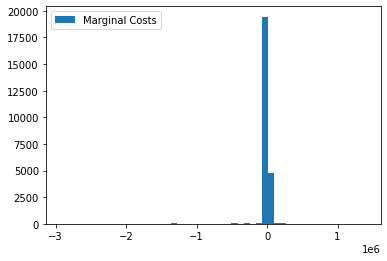

Computing markups ...
Finished after 00:00:00.



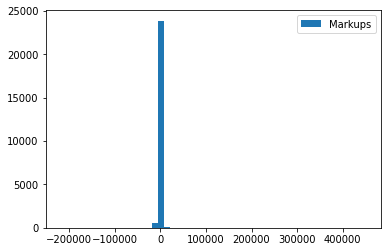

In [ ]:
costs = updated_results.compute_costs()
plt.hist(costs, bins=50)
plt.legend(["Marginal Costs"])
plt.show()
markups = updated_results.compute_markups(costs=costs)
plt.hist(markups, bins=50)
plt.legend(["Markups"])

In [ ]:
cs=updated_results.compute_consumer_surpluses()
sum(cs),np.mean(cs)
cs2=updated_results.compute_consumer_surpluses(eliminate_product_ids=["nonself"])
cs3=updated_results.compute_consumer_surpluses(eliminate_product_ids=["self"])
cs4=updated_results.compute_consumer_surpluses(eliminate_product_ids=["nonself","self"])
print([np.mean(cs),np.mean(cs2),np.mean(cs3),np.mean(cs4)]/np.mean(cs))
print(sum(cs),sum(cs2),sum(cs3),sum(cs4))

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...

Encountered a numerical error when computing a post-estimation output. Errors encountered: divide by zero.

Finished after 00:00:00.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...

Encountered a numerical error when computing a post-estimation output. Errors encountered: divide by zero.

Finished after 00:00:00.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...

Encountered a numerical error when computing a post-estimation output. Errors encountered: divide by zero.

Finished after 00:00:00.

[ 1. inf inf inf]
[302262.15712788] [inf] [inf] [inf]


In [ ]:
np.mean(updated_results.delta)

3.630702545682845

In [ ]:
import datetime

# Get the current date and time
current_time = datetime.datetime.now()

# Format the time as a string
time_string = current_time.strftime("%Y-%m-%d_%H-%M-%S")
if save:
    logit_results.to_pickle(f"./results/NL_len3_{time_string}_{drop_self}{drop_nonself}.pkl")

In [ ]:
elasticities = logit_results.compute_elasticities()

Computing elasticities with respect to prices ...
Finished after 00:00:00.



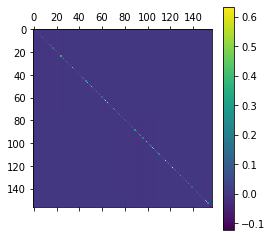

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
single_market = product_data['market_ids'] == '131-2015'
K=sum(single_market)
plt.colorbar(plt.matshow(elasticities[single_market][:,:K]))

In [ ]:
product_data[single_market].shape,K

((157, 26), 157)

In [ ]:
elasticities[single_market][:,:K]

array([[ 2.06030376e-02,  2.87372109e-06, -2.70931147e-03, ...,
         1.07992825e-06,  2.00271325e-06,  5.38004162e-08],
       [ 1.19236352e-05,  2.26960341e-02,  1.41619407e-05, ...,
        -7.06892446e-05,  2.00271325e-06,  5.38004162e-08],
       [-2.28110272e-03,  2.87372109e-06,  1.08018040e-02, ...,
         1.07992825e-06,  2.00271325e-06,  5.38004162e-08],
       ...,
       [ 1.19236352e-05, -1.88106176e-04,  1.41619407e-05, ...,
         4.22076353e-02,  2.00271325e-06,  5.38004162e-08],
       [ 1.19236352e-05,  2.87372109e-06,  1.41619407e-05, ...,
         1.07992825e-06, -2.53514521e-02, -3.27381634e-03],
       [ 1.19236352e-05,  2.87372109e-06,  1.41619407e-05, ...,
         1.07992825e-06, -1.21867373e-01,  9.32421040e-02]])

Computing diversion ratios with respect to prices ...
Finished after 00:00:00.



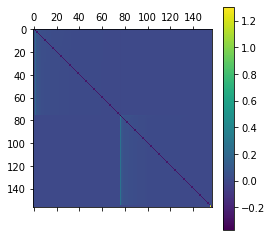

In [ ]:
diversions = logit_results.compute_diversion_ratios()
plt.colorbar(plt.matshow(diversions[single_market][:,:K]))